# 主成分分析

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
import os
import glob
import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import IncrementalPCA

In [ ]:
#pickleファイルを読み込むのに必須
!pip3 install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.3 MB/s 


In [ ]:
#ここでフォルダのpathを書いておいて、読み込み時にフォルダ内のファイル名だけ書けばよくしておく。
train_folder = "/content/drive/MyDrive/competition/Amex0824/data/train/"
test_folder = "/content/drive/MyDrive/competition/Amex0824/data/test/"
#ファイル名だけだと拡張子取れてないときがあるのでここに書いておく
extension = ".pkl"

In [ ]:
def get_file_list(folder = train_folder):
    """
    フォルダ内からファイル名を取り出しリストに渡す
    """
    train_files = sorted(glob.glob(os.path.join(folder, "*.pkl")))
    file_list = []
    for file in train_files:
        file_list.append(Path(file).stem)
    return file_list

In [ ]:
#試しに実行してみよう
a = get_file_list()
a

['after_pay', 'count', 'date', 'frequency', 'nunique']

In [ ]:
#試しに一つのファイルを読み込む用
#open('*****',"rb")の*****がパスの部分です。そこは読み込めるように変更お願いします
with open('/content/train/after_pay.pkl', "rb") as f:
    data = pickle.load(f)

data.head(5)

UnpicklingError: ignored

In [ ]:
pkl_files_list = ['after_pay.pkl','count.pkl','date.pkl','frequency.pkl','nunique.pkl']
for file in pkl_files_list:
    with open(train_folder + f'{file}', "rb") as fh:
        train = pickle.load(fh)
        print(file)

実装

In [ ]:
#csvファイルとして保存するかもなので拡張子もう一つ書いときます
extension_csv = '.csv'

In [ ]:
#carry out Incremetal PCA
def IPCA(df_train, df_test, features_name_train, features_name_test, name):
    """  受け取ったデータを主成分分析し、「主成分得点に変換された値」のデータを生成する関数
    
    Args:
    df_train(DataFrame)       : 学習用データ
    df_test(DataFrame)        : テストデータ
    features_name_train(list) : 学習用データのindex
    features_name_test(list)  : テストデータのindex
    name(list)                : 分析したfileの名前

    return :
    features_train(DataFrame) : 主成分得点に変換した学習用データ
    features_test(DataFrame)  : 主成分得点に変換したテストデータ
    
    """
    #分割回数
    n_batches = 100
    
    #第何主成分まで抽出するか決める(10次元)
    inc_pca = IncrementalPCA(n_components=10)

    #データをn_batchで分割して逐次的に計算
    for X_batch in np.array_split(df_train,n_batches):
        print(".",end="")
        inc_pca = inc_pca.partial_fit(X_batch)

    #num_featuresをPCAで変換された値に変形する(trainとtest両方変換する)
    features_train = inc_pca.transform(df_train)
    features_test = inc_pca.transform(df_test)
    del df_train,df_test
    
    #主成分で得たデータをデータフレーム型に変換
    features_train = pd.DataFrame(features_train,index = features_name_train,columns =[f"{name}_" + "PC{}".format(x+1) for x in range(len(inc_pca.explained_variance_ratio_))]) 
    features_test = pd.DataFrame(features_test,index = features_name_test,columns =[f"{name}_" + "PC{}".format(x+1) for x in range(len(inc_pca.explained_variance_ratio_))])  

    #寄与率を表示
    explained_variance_ratio_ = pd.DataFrame(inc_pca.explained_variance_ratio_,index=[f"{name}_" + "PC{}".format(x+1) for x in range(len(inc_pca.explained_variance_ratio_))])
    print(explained_variance_ratio_)

    #寄与率をリスト型に渡し、、for文で取り出し可能にする
    explained_variance_ratio_ = list(inc_pca.explained_variance_ratio_)
    
    #初期化
    cumulative_contribution_ratios = 0
    count_features = 0
    
    #累積寄与率を計算
    for i in explained_variance_ratio_:
        cumulative_contribution_ratios += i
        count_features = count_features + 1
        if cumulative_contribution_ratios >= 0.99:
            break
    print("累積寄与率")
    print(cumulative_contribution_ratios)
    print("\n")
    print("第何主成分までを利用するか")
    print(count_features)

    #trainを抽出
    features_train = features_train.iloc[:,:int(count_features)]
    features_train = pd.DataFrame(features_train)
    
    #testを抽出
    features_test = features_test.iloc[:,:int(count_features)]
    features_test = pd.DataFrame(features_test)

    #抽出したデータを返す
    return features_train, features_test

In [ ]:
def make_pc(train_folder = train_folder, test_folder = test_folder, extension = extension):
    #splitしてしてファイル名の「train_」を消す
    files_list = get_file_list()
    #files_list = list(['after_pay','count','date','frequency','nunique'])
    #split_files_list = []
    #for file in files_list:
        #split = list(file.split('train_'))
        #split = list(filter(lambda x: not len(x)==0,split))
        #split_files_list += split

    for file in files_list:
        with open(train_folder + f'{file}' + extension, "rb") as fh:
            train = pickle.load(fh)
            print(file)
            #下に行はもう一つの方法です(上のコードがダメなとき代わりに試してみてください)
            #train_file_name = train_folder + f"/{file}" + extension
            #train = pd.read_pickle(train_file_name)

        with open(test_folder + f'{file}' + extension, "rb") as fh:
            test = pickle.load(fh)
            print(file)
            #下に行はもう一つの方法です(上のコードがダメなとき代わりに試してみてください)
            #train_file_name = train_folder + f"/{file}" + extension
            #train = pd.read_pickle(train_file_name)

        #変数番号(行)を取っておく
        features_name_train = train.index
        features_name_test = test.index

        train_list = train.columns.tolist()
        test_list = test.columns.tolist()

        # 欠損値を -1 に補完
        train = train.fillna(-1)
        test = test.fillna(-1)

        #上で作った主成分分析にかける
        #返り値だった「features_train」がtrainに, 「features_test」がtestに入ります)
        train, test = IPCA(train, test, features_name_train, features_name_test, file)

        #make a csv-file (拡張子「.pkl」にするなら最後をextensionに変更)
        save_train = '/content/drive/MyDrive/competition/Amex0824/ipca_train/' + f"{file}" + extension_csv
        save_test = '/content/drive/MyDrive/competition/Amex0824/ipca_tset/' + f"{file}" + extension_csv
        train.to_pickle(save_train)
        test.to_pickle(save_test)

        del train,test

make_pc()

結合

In [ ]:
train_pickle_folder = "/content/drive/MyDrive/competition/Amex0824/ipca_train/"
test_pickle_folder = "/content/drive/MyDrive/competition/Amex0824/_test/"
extension = ".pkl"

In [ ]:
def get_file_list(folder = train_pickle_folder):
    train_files = sorted(glob.glob(os.path.join(folder, "*.pkl")))
    file_list = []
    for file in train_files:
        file_list.append(Path(file).stem)
    return file_list

In [ ]:
def merge_pca(train_pidkle_folder = train_pickle_folder, test_pickle_folder = test_pickle_folder, extension = extension):
    """pcaで得られたデータを結合して一つにまとめる関数

    return :
    df_train_all(DataFrame) : PCA通した学習用データを全結合したもの
    df_test_all(DataFrame)  : PCA通したテストデータを全結合したもの
    
    """
    files_list = get_file_list()
    split_files_list = []
    for file in files_list:
        split = list(file.split('train_'))
        split = list(filter(lambda x: not len(x)==0,split))
        split_files_list += split

    df_pca_train = pd.DataFrame() , df_pca_test = pd.DataFrame()
    for file in split_files_list:
        train_file_name = train_folder + f"/train_{file}" + extension
        test_file_name = test_folder + f"/test_{file}" + extension
        train = pd.read_pickle(train_file_name)
        test = pd.read_pickle(test_file_name)
    
        #for文でデータフレームを結合するコードを作る
        df_pca_train = pd.concat([df_pca_train,train], axis = 1)
        df_pca_test = pd.concat([df_pca_test,test], axis = 1)
        del train,test

    df_train_all = pd.DataFrame(pd.concat(df_pca_train, axis = 1, sort = False))
    df_test_all = pd.dataFrame(pd.concat(df_pca_test, axis = 1, sort = False))
    #make a pickle_file 
    save_train = '/content/drive/MyDrive/competition/Amex0824/data/ipca_train/df_train_all'+ extension
    save_test = '/content/drive/MyDrive/competition/Amex0824/data/ipca_tset/df_test_all'+ extension
    df_train_all.to_pickle(save_train)
    df_test_all.to_pickle(save_test)

merge_pca()

# permutation



Permutation Importance

https://www.kaggle.com/code/kenmatsu4/sklearn-permutation-importance/notebook





In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import gc
import numpy as np
import pandas as pd
import zipfile
import numpy.random as rd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

In [42]:
train_ipca = pd.read_pickle('/content/drive/MyDrive/competition/Amex0824/data/ipca_train/df_train_all.pkl')

In [43]:
train_ipca

,after_pay.pkl_PC1,after_pay.pkl_PC2,count.pkl_PC1,date.pkl_PC1,date.pkl_PC2,date.pkl_PC3,date.pkl_PC4,date.pkl_PC5,date.pkl_PC6,date.pkl_PC7,...,nunique.pkl_PC3,nunique.pkl_PC4,nunique.pkl_PC5,nunique.pkl_PC6,nunique.pkl_PC7,nunique.pkl_PC8,nunique.pkl_PC9,nunique.pkl_PC10,PC1,PC2
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.792036,-0.021208,0.850869,-1.406126,-0.049793,-0.380938,-0.765362,-0.422201,0.246151,-0.446322,...,-0.649401,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.969081,-168.313406
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.790675,-0.022269,0.850869,-1.037694,0.090119,-0.029977,-1.335747,-0.359705,0.294483,-0.623735,...,-0.649401,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.970086,-168.314749
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.330825,-0.024651,0.850869,-0.293457,-0.280492,2.307900,-1.119098,1.139195,-0.882136,0.740000,...,-0.649401,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,2189.431372,-56.574431
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.794137,-0.022477,0.850869,0.175731,-0.232409,-1.121780,-1.607717,0.195904,-0.064205,-0.318195,...,-0.649401,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1225.824650,-13.755297
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.789267,-0.025325,0.850869,0.859516,0.277764,2.223003,-1.256485,0.292063,-0.348169,-0.194827,...,-0.649401,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.975755,-168.304032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681,1.367483,-0.039584,0.850869,2.030858,0.827663,2.153724,0.888412,-1.320087,0.354228,-0.820850,...,0.494101,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,1225.820958,-13.748873
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681,0.748621,-0.035098,0.850869,2.178331,0.075519,1.874435,1.602436,-0.231341,-0.450729,0.513001,...,0.494101,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,1205.525095,-100.428546
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681,1.519288,-0.038526,0.850869,-2.698600,0.438761,1.872677,0.982771,-1.268229,0.350168,-0.667205,...,0.494101,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,-59.053159,-250.920749


In [44]:
# データの取得
#train = pd.read_parquet('/content/drive/MyDrive/competition/Amex0824/data/train.parquet')
train_labels = pd.read_csv('/content/drive/MyDrive/competition/Amex0824/data/train_labels.csv')

In [ ]:
train_labels

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1


In [45]:
# trainとtrain_labelsを結合
df = pd.merge(train_ipca,train_labels, on ="customer_ID")
del train_ipca, train_labels
gc.collect()

160

In [46]:
df

,customer_ID,after_pay.pkl_PC1,after_pay.pkl_PC2,count.pkl_PC1,date.pkl_PC1,date.pkl_PC2,date.pkl_PC3,date.pkl_PC4,date.pkl_PC5,date.pkl_PC6,...,nunique.pkl_PC4,nunique.pkl_PC5,nunique.pkl_PC6,nunique.pkl_PC7,nunique.pkl_PC8,nunique.pkl_PC9,nunique.pkl_PC10,PC1,PC2,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.792036,-0.021208,0.850869,-1.406126,-0.049793,-0.380938,-0.765362,-0.422201,0.246151,...,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.969081,-168.313406,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.790675,-0.022269,0.850869,-1.037694,0.090119,-0.029977,-1.335747,-0.359705,0.294483,...,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.970086,-168.314749,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.330825,-0.024651,0.850869,-0.293457,-0.280492,2.307900,-1.119098,1.139195,-0.882136,...,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,2189.431372,-56.574431,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.794137,-0.022477,0.850869,0.175731,-0.232409,-1.121780,-1.607717,0.195904,-0.064205,...,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1225.824650,-13.755297,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,-0.789267,-0.025325,0.850869,0.859516,0.277764,2.223003,-1.256485,0.292063,-0.348169,...,-0.127760,0.000793,-0.463024,-0.205866,-0.301466,-0.024657,-0.026571,1885.975755,-168.304032,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,1.367483,-0.039584,0.850869,2.030858,0.827663,2.153724,0.888412,-1.320087,0.354228,...,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,1225.820958,-13.748873,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,0.748621,-0.035098,0.850869,2.178331,0.075519,1.874435,1.602436,-0.231341,-0.450729,...,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,1205.525095,-100.428546,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,1.519288,-0.038526,0.850869,-2.698600,0.438761,1.872677,0.982771,-1.268229,0.350168,...,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,-59.053159,-250.920749,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,1.525559,-0.042774,0.850869,-2.656181,-0.094187,-1.106540,0.600638,-1.125261,0.481594,...,-0.533286,0.017440,-0.448783,0.116736,-1.519872,0.098849,0.427704,-59.043498,-250.894549,0


In [47]:
# 説明変数と目的変数に分ける
features = [col for col in df.columns if col not in ['customer_ID']]
df = df[features]
X = df.drop("target", axis=1)
y = df["target"]

In [48]:
# trainととvalidに分ける
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)
mse_scorer = make_scorer(amex_metric)

In [50]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

[LGBM](https://datawokagaku.com/lightgbm/#LightGBM)

In [51]:
rd.seed(123)
eval_result = {}
callbacks = [lgb.record_evaluation(eval_result)]

params_fit = {'X': X_train,
              'y': y_train,
              'eval_set': (X_valid, y_valid),
              'early_stopping_rounds': 5,
              'verbose': True,
              'eval_metric':'amex_metric()'
             }
model = lgb.LGBMRegressor(objective="regression", n_estimators=100, importance_type="gain", random_state=123)
gbm = model.fit(**params_fit, callbacks=callbacks)
# gbm.evals_result_

[1]	valid_0's l2: 0.173683
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.162977
[3]	valid_0's l2: 0.154305
[4]	valid_0's l2: 0.147059
[5]	valid_0's l2: 0.140992
[6]	valid_0's l2: 0.136057
[7]	valid_0's l2: 0.131955
[8]	valid_0's l2: 0.128449
[9]	valid_0's l2: 0.125372
[10]	valid_0's l2: 0.122821
[11]	valid_0's l2: 0.120612
[12]	valid_0's l2: 0.118732
[13]	valid_0's l2: 0.117171
[14]	valid_0's l2: 0.115769
[15]	valid_0's l2: 0.11458
[16]	valid_0's l2: 0.113577
[17]	valid_0's l2: 0.112494
[18]	valid_0's l2: 0.111703
[19]	valid_0's l2: 0.110979
[20]	valid_0's l2: 0.110195
[21]	valid_0's l2: 0.109653
[22]	valid_0's l2: 0.109164
[23]	valid_0's l2: 0.108745
[24]	valid_0's l2: 0.108376
[25]	valid_0's l2: 0.107991
[26]	valid_0's l2: 0.107583
[27]	valid_0's l2: 0.107259
[28]	valid_0's l2: 0.106891
[29]	valid_0's l2: 0.106649
[30]	valid_0's l2: 0.106413
[31]	valid_0's l2: 0.106117
[32]	valid_0's l2: 0.105919
[33]	valid_0's l2: 0.10562
[34]	valid_0's l2: 0.10542

In [52]:
# Feature importance
importance_df = pd.DataFrame({"gain":model.feature_importances_}, index=X.columns).sort_values("gain", ascending=False)
print("[Feature importance]")
display(importance_df)

[Feature importance]


,gain
frequency.pkl_PC2,701032.511415
after_pay.pkl_PC2,405175.112690
after_pay.pkl_PC1,333113.922662
nunique.pkl_PC2,245450.014529
PC1,79362.950657
frequency.pkl_PC1,64705.059448
nunique.pkl_PC1,40375.907846
frequency.pkl_PC9,35653.733066
nunique.pkl_PC7,32748.900110
frequency.pkl_PC5,16848.065191


In [53]:
# リスト化する(Feature importanceの重要度順)
df1 = importance_df.sort_values("gain", ascending=False)
df1.index.values

array(['frequency.pkl_PC2', 'after_pay.pkl_PC2', 'after_pay.pkl_PC1',
       'nunique.pkl_PC2', 'PC1', 'frequency.pkl_PC1', 'nunique.pkl_PC1',
       'frequency.pkl_PC9', 'nunique.pkl_PC7', 'frequency.pkl_PC5', 'PC2',
       'frequency.pkl_PC4', 'frequency.pkl_PC6', 'nunique.pkl_PC9',
       'nunique.pkl_PC5', 'date.pkl_PC1', 'nunique.pkl_PC3',
       'nunique.pkl_PC6', 'frequency.pkl_PC7', 'nunique.pkl_PC4',
       'frequency.pkl_PC3', 'date.pkl_PC4', 'count.pkl_PC1',
       'nunique.pkl_PC10', 'frequency.pkl_PC10', 'nunique.pkl_PC8',
       'date.pkl_PC3', 'frequency.pkl_PC8', 'date.pkl_PC9',
       'date.pkl_PC2', 'date.pkl_PC5', 'date.pkl_PC6', 'date.pkl_PC7',
       'date.pkl_PC10', 'date.pkl_PC8'], dtype=object)

In [54]:
# Permutation importance
print("[Permutation importance]")
result = permutation_importance(model, X_train, y_train, scoring=mse_scorer, n_repeats=10, n_jobs=1, random_state=42)
result_df = pd.DataFrame({"importances_mean":result["importances_mean"], "importances_std":result["importances_std"]}, index=X.columns)
display(result_df.sort_values("importances_mean", ascending=False))

[Permutation importance]


,importances_mean,importances_std
after_pay.pkl_PC1,0.139756,0.000276
after_pay.pkl_PC2,0.063909,0.000141
PC1,0.045295,0.000297
nunique.pkl_PC2,0.040246,0.000223
frequency.pkl_PC2,0.036397,0.000159
frequency.pkl_PC1,0.015596,0.000199
PC2,0.014572,0.000119
nunique.pkl_PC1,0.010792,0.000081
nunique.pkl_PC7,0.007290,0.000100
frequency.pkl_PC9,0.006391,0.000078


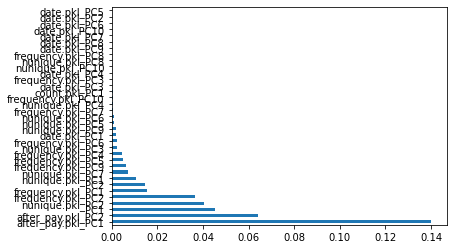

In [57]:
# グラフ(表示しなくても良い)
result_df.sort_values("importances_mean", ascending=False).importances_mean.plot.barh()

In [58]:
# リスト化する(Permutation importanceの重要度順)
df = result_df.sort_values("importances_mean", ascending=True)
df.index.values

array(['date.pkl_PC7', 'date.pkl_PC2', 'date.pkl_PC5', 'date.pkl_PC6',
       'date.pkl_PC8', 'date.pkl_PC10', 'date.pkl_PC9',
       'frequency.pkl_PC8', 'nunique.pkl_PC8', 'nunique.pkl_PC10',
       'date.pkl_PC4', 'frequency.pkl_PC3', 'date.pkl_PC3',
       'count.pkl_PC1', 'frequency.pkl_PC10', 'nunique.pkl_PC4',
       'frequency.pkl_PC7', 'nunique.pkl_PC6', 'nunique.pkl_PC5',
       'nunique.pkl_PC9', 'date.pkl_PC1', 'frequency.pkl_PC6',
       'nunique.pkl_PC3', 'frequency.pkl_PC4', 'frequency.pkl_PC5',
       'frequency.pkl_PC9', 'nunique.pkl_PC7', 'nunique.pkl_PC1', 'PC2',
       'frequency.pkl_PC1', 'frequency.pkl_PC2', 'nunique.pkl_PC2', 'PC1',
       'after_pay.pkl_PC2', 'after_pay.pkl_PC1'], dtype=object)

In [ ]:
# 0より小さい値が一定数あるならその変数を選択すれば良い(変数が少ないから使わないかも)
df = result_df.sort_values("importances_mean", ascending=True)
df[df.importances_mean < 0].index.values